# Initialisation

In [1]:
#--------------- Importing key libraries and modules ---------------#
import time
from datetime import datetime, timedelta

import numpy as np
import scipy as spy
import scipy.constants as con
import math
from scipy.interpolate import interp1d
from uncertainties import ufloat # for managing errors in the data
from uncertainties import unumpy
from uncertainties.umath import * # for mathematical operations, e.g. unumpy.sin(x)

import speasy as spz
import SerPyShock as SP
import data_functions as data_func
import calc_functions as calc_func
import rankine_functions as RH  
import plot_functions as plot_func

import json
import pandas as pd
import import_ipynb

import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# Importing speasy databases
amda_tree = spz.inventories.tree.amda
cda_tree = spz.inventories.tree.cda
ssc_tree = spz.inventories.tree.ssc

## Input Satellite Data

In [3]:
#--------------- Input date and time of the shock, and the period of analysis before and after ---------------#

# Date of the shock
date = ['06', '05', '2015'] # DD-MM-YYYY format

# Time of the shock in the solar wind
t1 = ['00', '55', '00'] # HH:MM:SS format

# Time of the shock in the magnetosheath
t3 = ['01', '40', '40']

# Name of the spacecraft in the magnetosheath and solar wind, i.e. THEMIS cluster, WIND
name_spacecraft_msh = "THE"
name_spacecraft_sw = "WIND"

# Minutes observed before and after the shock in SW and MSH
time_obs = 20 # mins

start_date_sw, end_date_sw, time_shock_sw = data_func.find_time(date, t1, time_obs)
start_date_msh, end_date_msh, time_shock_msh = data_func.find_time(date, t3, time_obs)

### Json management

In [4]:
# The name of the json file to create/save the data in
name_file = 'data_shock.json'

# Formatting the date for json file
shock_date_json = date[0] +'/'+ date[1] +'/'+ date[2]

# Formatting the time for json file
shock_t1_json = [int(t1[0]), int(t1[1]), int(t1[2])]

# Formatting the time for json file
shock_t3_json = [int(t3[0]), int(t3[1]), int(t3[2])]

# Index of the shock for json file
index = '15'

# Solar Wind Data

In [5]:
#-------------- find the coordinates of the satellite ----------------
S1 = data_func.get_coordinate(name_spacecraft_sw, time_shock_sw)[0]

the time is: ['2015-05-06T00:50:00.000000000']
the satellite coordinate are: [[237.92738659 -91.97729899  13.63589939]]


## One Window

### Window Parameters

In [6]:
#--------------- Defining the variables for multiple averaging windows ---------------#

# Change the value for the averaging windows
up_shk_sw = time_shock_sw - timedelta(minutes = 5)
dw_shk_sw = time_shock_sw + timedelta(minutes = 5)
min_up_dur_sw = timedelta(minutes = 3)
max_up_dur_sw = timedelta(minutes = 10)
min_dw_dur_sw = timedelta(minutes = 3)
max_dw_dur_sw = timedelta(minutes = 10)
tcad_sw = timedelta(seconds = 10)

# Define the list of time up and down for our averaging range
time_up_sw = (time_shock_sw - max_up_dur_sw, up_shk_sw)
time_dw_sw = (dw_shk_sw, time_shock_sw + max_dw_dur_sw)

# Define variable to plot the minimum and maximum windows
up_window_sw = (up_shk_sw - min_up_dur_sw, up_shk_sw - max_up_dur_sw)
down_window_sw = (dw_shk_sw + min_dw_dur_sw, dw_shk_sw + max_dw_dur_sw)

### Magnetic Field

In [7]:
#--------------- Retrieves magnetic field data ---------------#
time_mag_sw, B_sw, B_unit_sw = data_func.get_Bfield(name_spacecraft_sw, start_date_sw, end_date_sw)

Bx_sw = np.array([b_sw[0] for b_sw in B_sw])
By_sw = np.array([b_sw[1] for b_sw in B_sw])
Bz_sw = np.array([b_sw[2] for b_sw in B_sw])

# Variable defined for the multiple averaging windows
datetime_objects_sw = pd.to_datetime(time_mag_sw)
freq = 'ns'
datetime_index_sw = pd.DatetimeIndex(datetime_objects_sw).floor(freq)

# Defining the averaging windows for B_up, B_dw and filtering the magnetic field
# By filtering, we are slicing the data to look at a smaller range of data
filtered_Bx_up_sw, filtered_By_up_sw, filtered_Bz_up_sw = data_func.filter_B(time_mag_sw, Bx_sw, By_sw, Bz_sw, time_up_sw)
filtered_Bx_dw_sw, filtered_By_dw_sw, filtered_Bz_dw_sw = data_func.filter_B(time_mag_sw, Bx_sw, By_sw, Bz_sw, time_dw_sw)

# Ufloat objects for the average of the upstream and downstream magnetic field components, and their associated uncertainty
Bx_up_sw = calc_func.mean_std(filtered_Bx_up_sw) ; By_up_sw = calc_func.mean_std(filtered_By_up_sw) ; Bz_up_sw = calc_func.mean_std(filtered_Bz_up_sw)
Bx_dw_sw = calc_func.mean_std(filtered_Bx_dw_sw) ; By_dw_sw = calc_func.mean_std(filtered_By_dw_sw) ; Bz_dw_sw = calc_func.mean_std(filtered_Bz_dw_sw)

# Creates a vector B for the averaging window
vec_B_up_sw = np.array([Bx_up_sw, By_up_sw, Bz_up_sw])
vec_B_dw_sw = np.array([Bx_dw_sw, By_dw_sw, Bz_dw_sw])

#print("There are",len(B_sw),"data values of the magnetic field in this date range.")
#print("There are",len(filtered_Bx_up_sw),"data values of the sliced magnetic field in this time range.\n")

data_func.print_data("Upstream Magnetic Field", vec_B_up_sw, B_unit_sw)
data_func.print_data("Downstream Magnetic Field", vec_B_dw_sw, B_unit_sw)

Upstream Magnetic Field: [-0.1, 5.45, 2.2] ± [0.7, 0.21, 0.5] nT
Downstream Magnetic Field: [-2.6, 11.5, 4.5] ± [0.9, 2.2, 2.9] nT


### Velocity

In [8]:
#--------------- Retrieves velocity data ---------------#
time_vel_sw, V_sw, V_unit_sw = data_func.get_velocity(name_spacecraft_sw, start_date_sw, end_date_sw)

Vx_sw = np.array([v_sw[0] for v_sw in V_sw])
Vy_sw = np.array([v_sw[1] for v_sw in V_sw])
Vz_sw = np.array([v_sw[2] for v_sw in V_sw])

# Defining the averaging windows for V_up, V_dw and filtering the velocity
filtered_Vx_up_sw, filtered_Vy_up_sw, filtered_Vz_up_sw = data_func.filter_V(time_vel_sw, Vx_sw, Vy_sw, Vz_sw, time_up_sw)
filtered_Vx_dw_sw, filtered_Vy_dw_sw, filtered_Vz_dw_sw = data_func.filter_V(time_vel_sw, Vx_sw, Vy_sw, Vz_sw, time_dw_sw)

# Ufloat objects for the average of the upstream and downstream velocity components, and their associated uncertainty
Vx_up_sw = calc_func.mean_std(filtered_Vx_up_sw) ; Vy_up_sw = calc_func.mean_std(filtered_Vy_up_sw) ; Vz_up_sw = calc_func.mean_std(filtered_Vz_up_sw)
Vx_dw_sw = calc_func.mean_std(filtered_Vx_dw_sw) ; Vy_dw_sw = calc_func.mean_std(filtered_Vy_dw_sw) ; Vz_dw_sw = calc_func.mean_std(filtered_Vz_dw_sw)

# create a vector V for a defined range
vec_V_up_sw = np.array([Vx_up_sw, Vy_up_sw, Vz_up_sw])
vec_V_dw_sw = np.array([Vx_dw_sw, Vy_dw_sw, Vz_dw_sw])

#print("There are",len(V_sw),"data values of the bulk flow velocity in this date range.")
#print("There are",len(filtered_Vx_up_sw),"data values of the sliced bulk flow velocity in this time range.\n")

data_func.print_data("Upstream Velocity", vec_V_up_sw, V_unit_sw)
data_func.print_data("Downstream Velocity", vec_V_dw_sw, V_unit_sw)

Upstream Velocity: [-382.8, -30.7, -10] ± [2.5, 3.4, 4] km/s
Downstream Velocity: [-453, -47.4, -23] ± [5, 0.6, 4] km/s


### Density

In [9]:
#--------------- Retrieves density data ---------------#
time_rho_sw, rho_sw, rho_unit_sw = data_func.get_density(name_spacecraft_sw, start_date_sw, end_date_sw)

Rho_sw = np.array([Density_sw[0] for Density_sw in rho_sw])
Mass_rho_sw = Rho_sw*con.m_p # Multiplying by mass of proton to obtain mass density

# Defining the averaging windows for n_up, n_dw
filtered_rho_up_sw = data_func.filter_N(time_rho_sw, Rho_sw, time_up_sw)
filtered_rho_dw_sw = data_func.filter_N(time_rho_sw, Rho_sw, time_dw_sw)

density_up_sw = calc_func.mean_std(filtered_rho_up_sw)
density_dw_sw = calc_func.mean_std(filtered_rho_dw_sw)

#print("There are",len(rho_sw),"data values of the bulk flow velocity in this date range.")
#print("There are",len(filtered_rho_up_sw),"data values of the sliced bulk flow velocity in this time range.\n")

data_func.print_data("Upstream Density", density_up_sw, rho_unit_sw)
data_func.print_data("Downstream Density", density_dw_sw, rho_unit_sw)

Upstream Density: 4.6±0.4 cm-3
Downstream Density: 12.4±0.7 cm-3


### Shock Velocity

In [10]:
#--------------- Computing the normals: MC, VC, MX1, MX2, MX3 ---------------#

# Define the delta vectors used in all methods
dB_sw = (vec_B_dw_sw) - (vec_B_up_sw)
dV_sw = (vec_V_dw_sw) - (vec_V_up_sw)

method_names = ["MC", "MX1", "MX2", "MX3", "VC"] # Names for printing
function_names = [calc_func.normal_MC, calc_func.normal_MX1, calc_func.normal_MX2, calc_func.normal_MX3, calc_func.normal_VC] # Arguments for the normal_method() function
normals_sw = []
angles_sw = []

# Calculate and print normal vectors and angles
for i in range(len(method_names)):
    normal_i, angle_i = calc_func.normal_method(vec_B_up_sw, vec_B_dw_sw, dB_sw, dV_sw, function_names[i])
    normals_sw.append(normal_i) ; angles_sw.append(angle_i)
    data_func.print_data("Normal", normal_i, method=method_names[i])
    print("Angle: {:fP} degrees\n".format(angle_i))

Method MC
Normal: [-0.93, -0.3, -0.2] ± [0.13, 0.4, 1.1] 
Angle: 69±16 degrees

Method MX1
Normal: [-0.93, -0.31, -0.21] ± [0.07, 0.18, 0.09] 
Angle: 69±16 degrees

Method MX2
Normal: [-0.93, -0.31, -0.22] ± [0.07, 0.18, 0.09] 
Angle: 69±16 degrees

Method MX3
Normal: [-0.93, -0.31, -0.22] ± [0.07, 0.18, 0.10] 
Angle: 69±16 degrees

Method VC
Normal: [-0.956, -0.23, -0.18] ± [0.018, 0.05, 0.08] 
Angle: 75±7 degrees



In [11]:
def velocity_shock(vel_up, vel_down, dens_up, dens_down, normal):
    """
    Function to estimate the speed of the shock.
        v_sh = Δ(ρV)/Δρ . n
    The Δ represents the difference in the downstream and upstream quantities.
    V is the bulk flow speed, ρ is the mass density, and n is the (unit) normal vector.
    
    Input
        vel_up - the bulk flow speed in the upstream
        vel_down - the bulk flow speed in the downstream
        dens_up - the mass density in the upstream
        dens_down - the mass density in the downstream
        normal - the normal vector of the shock
    Output
        v_sh - the shock velocity/speed
    """
    flow_down = dens_down * vel_down
    flow_up = dens_up * vel_up
    return abs(np.dot(np.subtract(flow_down, flow_up)/np.subtract(dens_down, dens_up), normal))

def velocity_shock_sw(normal):
    """
    Function to calculate the velocity of the shock given the density and velocity upstream and downstream of the shock
    
    Input
        normal - the normal vector to be used in the calculation of the velocity of the shock
    Output
        speed - the shock speed as calculated using the 'velocity_shock' method
    """
    return velocity_shock(vec_V_up_sw, vec_V_dw_sw, density_up_sw, density_dw_sw, normal)

velocities_sw = []
# Calculate and print the velocity of the shocks
for i in range(len(normals_sw)):
    vel = velocity_shock_sw(normals_sw[i])
    velocities_sw.append(vel)
    data_func.print_data("Shock Speed", vel, V_unit_sw, method_names[i])
    print("")

Method MC
Shock Speed: 484±48 km/s

Method MX1
Shock Speed: 483±27 km/s

Method MX2
Shock Speed: 483±26 km/s

Method MX3
Shock Speed: 483±26 km/s

Method VC
Shock Speed: 492±13 km/s



## Trotta Method

In [12]:
# Determining the extended velocity vector to be used in the Trotta method calculatio
data_sw = V_sw

# Number of indexes to extend
num_indexes_sw = np.shape(B_sw)[0]

# Generate an array of indices
indices_sw = np.arange(data_sw.shape[0])

# Interpolate each column separately
interpolated_data_V_sw = np.empty((num_indexes_sw, data_sw.shape[1]))
for col in range(data_sw.shape[1]):
    interpolator_sw = interp1d(indices_sw, data_sw[:, col], kind='cubic')
    interpolated_data_V_sw[:, col] = interpolator_sw(np.linspace(0, indices_sw[-1], num_indexes_sw))
    
# Make an array with the data
indices_rho_sw = np.linspace(0, len(rho_sw) - 1, num=len(rho_sw))
new_indices_rho_sw = np.linspace(0, len(rho_sw) - 1, num=np.shape(B_sw)[0])

# Flattens the arrays
original_data_flat_sw = np.ravel(rho_sw)
indices_flat_sw = np.ravel(indices_rho_sw)

# Perfors linear interpolation
extended_rho_sw = np.interp(new_indices_rho_sw, indices_flat_sw, original_data_flat_sw)

# Reshape extended_density
extended_rho_reshaped_sw = extended_rho_sw.reshape((np.shape(B_sw)[0], 1))

In [13]:
#--------------- Computing the normals using SerPyShock for one window: MC, MX1, MX2, MX3 ---------------#

nom_vec_B_up_sw = data_func.nom_vals(vec_B_up_sw)
nom_vec_B_dw_sw = data_func.nom_vals(vec_B_dw_sw)
nom_vec_V_up_sw = data_func.nom_vals(vec_V_up_sw)
nom_vec_V_dw_sw = data_func.nom_vals(vec_V_dw_sw)

print("One Window:\n")
# MC Method
MC_sw = SP.calc_MC(nom_vec_B_up_sw, nom_vec_B_dw_sw, "GSE")
print("Method MC\nNormal:", MC_sw[0], "\nAngle:", MC_sw[1])

# MX1 Method
MX1_sw = SP.calc_MX1(nom_vec_B_up_sw, nom_vec_B_dw_sw, nom_vec_V_up_sw, nom_vec_V_dw_sw, "GSE")
print("\nMethod MX1\nNormal:", MX1_sw[0], "\nAngle:", MX1_sw[1])

# MX2 Method
MX2_sw = SP.calc_MX2(nom_vec_B_up_sw, nom_vec_B_dw_sw, nom_vec_V_up_sw, nom_vec_V_dw_sw, "GSE")
print("\nMethod MX2\nNormal:", MX2_sw[0], "\nAngle:", MX2_sw[1])

# MX3 Method
MX3_sw = SP.calc_MX3(nom_vec_B_up_sw, nom_vec_B_dw_sw, nom_vec_V_up_sw, nom_vec_V_dw_sw, "GSE")
print("\nMethod MX3\nNormal:", MX3_sw[0], "\nAngle:", MX3_sw[1])

#---------- Calculating with multiple averaging windows ----------#

# Calculate the normal with averaging windows
n_sw, theta_Bn_sw, rB_sw, ex_sw = SP.MX_stats(datetime_index_sw, B_sw, datetime_index_sw, interpolated_data_V_sw, time_shock_sw, up_shk_sw, dw_shk_sw, min_up_dur_sw, max_up_dur_sw, min_dw_dur_sw, max_dw_dur_sw, tcad_sw, "GSE")
sp_normals_sw = np.array([n_sw.MC, n_sw.MX1, n_sw.MX2, n_sw.MX3])
sp_angles_sw = np.array([theta_Bn_sw.MC, theta_Bn_sw.MX1, theta_Bn_sw.MX2, theta_Bn_sw.MX3])

# Calculate the velocity with averaging windows
def window_velocities_sw(n_sw):
    """
    Function to calculate the normal vector using the SerPyShock module
    The calculation is done for a variety of different window lengths
    The SerPyShock module Vsh_stats() is used to perform this task
        nsh_sw - Array containing shock speed computed per each window choice.
        ex_sw - Object containing values of shock speed obtained with the 
        smallest and largest possible choice of upstream/downstream windows.
    Input
        n_sw - the normal vector used in the calculation of the shock velocity
    Output
         vsh_sw - the list of shock velocities for each window length in the calculation
    """
    V_sw = interpolated_data_V_sw
    Rho_sw = extended_rho_reshaped_sw
    vsh_sw, ex_sw = SP.Vsh_stats(n_sw, datetime_index_sw, V_sw, Rho_sw, time_shock_sw, up_shk_sw, dw_shk_sw, min_up_dur_sw, max_up_dur_sw, min_dw_dur_sw, max_dw_dur_sw, tcad_sw)
    # Returns shock speeds for each window
    return vsh_sw

# Calculate and compare the average of the normal from Trotta
avg_normals_sw = []
avg_angles_sw = []
avg_velocities_sw = []
avg_speeds_sw = []

print("\nTrotta Averaging Windows:")
for i in range(len(sp_normals_sw)):
    print("\nMethod "+method_names[i])
    
    normal = sp_normals_sw[i]
    avg_normal = calc_func.mean_std(normal, 0)
    avg_normals_sw.append(avg_normal)
    data_func.print_data("Normal", avg_normal)
    
    angle = sp_angles_sw[i]
    avg_angle = calc_func.mean_std(angle)
    avg_angles_sw.append(avg_angle)
    data_func.print_data("Angle", avg_angle)

    window_speeds = window_velocities_sw(data_func.nom_vals(avg_normal))
    
    avg_speed = calc_func.mean_std(window_speeds)
    avg_speeds_sw.append(avg_speed)
    data_func.print_data("Shock Speed", avg_speed, V_unit_sw)

One Window:

Method MC
Normal: [-0.927968   -0.31133841 -0.20480182] 
Angle: 69.30825952032582

Method MX1
Normal: [-0.92706027 -0.30717246 -0.21495196] 
Angle: 69.30957099763037

Method MX2
Normal: [-0.9270419  -0.30709282 -0.21514485] 
Angle: 69.30962138137546

Method MX3
Normal: [-0.9270269  -0.30702789 -0.21530212] 
Angle: 69.30966316431287

Trotta Averaging Windows:

Method MC
Normal: [-0.86, -0.25, -0.38] ± [0.05, 0.10, 0.21] 
Angle: 68.0±2.6 
Shock Speed: 461±4 km/s

Method MX1
Normal: [-0.932, -0.315, -0.174] ± [0.010, 0.020, 0.024] 
Angle: 69.2±2.8 
Shock Speed: 496±4 km/s

Method MX2
Normal: [-0.933, -0.316, -0.173] ± [0.010, 0.019, 0.024] 
Angle: 69.3±2.8 
Shock Speed: 496±4 km/s

Method MX3
Normal: [-0.933, -0.316, -0.172] ± [0.010, 0.018, 0.024] 
Angle: 69.3±2.8 
Shock Speed: 496±4 km/s


## Rankine Hugoniot Analysis

### Temperature

In [14]:
#--------------- Retrieves temperature data ---------------#
time_pres_sw, temp_sw, temp_unit_sw = data_func.get_temperature(name_spacecraft_sw, start_date_sw, end_date_sw)

Temp_sw = np.array([Temp_sw[0] for Temp_sw in temp_sw])

if name_spacecraft_sw=="WIND":
    Pres_sw = calc_func.pressure_vth(Mass_rho_sw, Temp_sw)
else:
    Pres_sw = calc_func.pressure_temp(Rho_sw, Temp_sw)

# Defining the averaging windows for p_up, p_dw
filtered_pres_up_sw = data_func.filter_P(time_pres_sw, Pres_sw, time_up_sw)
filtered_pres_dw_sw = data_func.filter_P(time_pres_sw, Pres_sw, time_dw_sw)

pres_up_sw = calc_func.mean_std(filtered_pres_up_sw)
pres_dw_sw = calc_func.mean_std(filtered_pres_dw_sw)

#print("There are",len(Temp_sw),"data values of the magnetic field in this date range.")
#print("There are",len(filtered_pres_up_sw),"data values of the sliced magnetic field in this time range.\n")

data_func.print_data("Upstream Pressure", pres_up_sw*10**9, "nPa")
data_func.print_data("Downstream Pressure", pres_dw_sw*10**9, "nPa")

Upstream Pressure: 0.00145±0.00028 nPa
Downstream Pressure: 0.0126±0.0010 nPa


In [15]:
RH.rankine_methods(vec_B_up_sw, vec_B_dw_sw, B_unit_sw, vec_V_up_sw, vec_V_dw_sw, V_unit_sw, density_up_sw, density_dw_sw, rho_unit_sw, pres_up_sw, pres_dw_sw, avg_normals_sw, avg_speeds_sw, method_names)

Method MC 
Speed 461±4 km/s 

Upstream B-field: -2.2±0.9 nT
Downstream B-field: -2.4±2.0 nT
0.11267 sigma difference
Equation [B_n] = 0 is conserved.

Upstream Mass Flow: -510±141 km/scm-3
Downstream Mass Flow: -477±400 km/scm-3
0.12128 sigma difference
Equation [rho*V_n] = 0 is conserved.

Upstream Quantity: [-64, 407, -126] ± [92, 192, 218] nTkm/s
Downstream Quantity: [8, 271, -200] ± [120, 365, 288] nTkm/s
Equation [B_n*V - V_n*B] = 0 is conserved.

Upstream Pressure: 0.11±0.05 nPa
Downstream Pressure: 0.10±0.05 nPa
0.13336 sigma difference
Equation [rho*v_n^2+P+(B^2/2-B_n^2)/mu0] = 0 is conserved.

Upstream Pressure: [0.06, -0.043, -0.11] ± [0.06, 0.029, 0.08] nPa
Downstream Pressure: [0.05, -0.03, -0.11] ± [0.10, 0.04, 0.14] nPa
Equation [rho*v_n*V_t-(B_nB_t)/mu0] = 0 is conserved.


Method MX1 
Speed 496±4 km/s 

Upstream B-field: -2.0±0.7 nT
Downstream B-field: -2.0±1.2 nT
0.040521 sigma difference
Equation [B_n] = 0 is conserved.

Upstream Mass Flow: -588±59 km/scm-3
Downstream

# Magnetosheath Data                                                                                                                                                                                                                                                                                                                                           

In [16]:
#-------------- find the coordinates of the satellite ----------------
S2 = data_func.get_coordinate(name_spacecraft_msh, time_shock_msh)[0]

the time is: ['2015-05-06T01:36:00.000000000' '2015-05-06T01:37:00.000000000'
 '2015-05-06T01:38:00.000000000' '2015-05-06T01:39:00.000000000'
 '2015-05-06T01:40:00.000000000' '2015-05-06T01:41:00.000000000'
 '2015-05-06T01:42:00.000000000' '2015-05-06T01:43:00.000000000'
 '2015-05-06T01:44:00.000000000' '2015-05-06T01:45:00.000000000']
the satellite coordinate are: [[11.5978   1.95457 -2.10752]
 [11.5929   1.96236 -2.10913]
 [11.5881   1.97014 -2.11073]
 [11.5832   1.97791 -2.11232]
 [11.5783   1.98567 -2.11391]
 [11.5733   1.99343 -2.11549]
 [11.5683   2.00118 -2.11706]
 [11.5632   2.00893 -2.11863]
 [11.5582   2.01667 -2.12019]
 [11.553    2.0244  -2.12174]]


## One Window

### Window Parameters

In [17]:
#--------------- Defining the variables for multiple averaging windows ---------------#

# Change the value for the averaging windows
up_shk_msh = time_shock_msh - timedelta(minutes = 5)
dw_shk_msh = time_shock_msh + timedelta(minutes = 5)
min_up_dur_msh = timedelta(minutes = 3)
max_up_dur_msh = timedelta(minutes = 10)
min_dw_dur_msh = timedelta(minutes = 3)
max_dw_dur_msh = timedelta(minutes = 10)
tcad_msh = timedelta(seconds = 10)

# Define the list of time up and down for our averaging range
time_up_msh = (time_shock_msh - max_up_dur_msh, up_shk_msh)
time_dw_msh = (dw_shk_msh, time_shock_msh + max_dw_dur_msh)

#define variable to plot the minimum and maximum windows
up_window_msh = (up_shk_msh - min_up_dur_msh,up_shk_msh - max_up_dur_msh)
down_window_msh = (dw_shk_msh + min_dw_dur_msh, dw_shk_msh + max_dw_dur_msh)

### Magnetic Field

In [18]:
#--------------- Retrieves magnetic field data ---------------#
time_mag_msh, B_msh, B_unit_msh = data_func.get_Bfield(name_spacecraft_msh, start_date_msh, end_date_msh)

# data_func.get_coordinate(name_spacecraft)

Bx_msh = np.array([b_msh[0] for b_msh in B_msh])
By_msh = np.array([b_msh[1] for b_msh in B_msh])
Bz_msh = np.array([b_msh[2] for b_msh in B_msh])

# Variable defined for the multiple averaging windows
datetime_objects_msh = pd.to_datetime(time_mag_msh)
freq = 'ns'
datetime_index_msh = pd.DatetimeIndex(datetime_objects_msh).floor(freq)

# Defining the averaging windows for B_up, B_dw and filtering the magnetic field
filtered_Bx_up_msh, filtered_By_up_msh, filtered_Bz_up_msh = data_func.filter_B(time_mag_msh, Bx_msh, By_msh, Bz_msh, time_up_msh)
filtered_Bx_dw_msh, filtered_By_dw_msh, filtered_Bz_dw_msh = data_func.filter_B(time_mag_msh, Bx_msh, By_msh, Bz_msh, time_dw_msh)

# Ufloat objects for the average of the upstream and downstream magnetic field components, and their associated uncertainty
Bx_up_msh = calc_func.mean_std(filtered_Bx_up_msh) ; By_up_msh = calc_func.mean_std(filtered_By_up_msh) ; Bz_up_msh = calc_func.mean_std(filtered_Bz_up_msh)
Bx_dw_msh = calc_func.mean_std(filtered_Bx_dw_msh) ; By_dw_msh = calc_func.mean_std(filtered_By_dw_msh) ; Bz_dw_msh = calc_func.mean_std(filtered_Bz_dw_msh)

# Creates a vector B for the averaging window
vec_B_up_msh = np.array([Bx_up_msh, By_up_msh, Bz_up_msh])
vec_B_dw_msh = np.array([Bx_dw_msh, By_dw_msh, Bz_dw_msh])

#print("There are",len(B_msh),"data values of the magnetic field in this date range.")
#print("There are",len(filtered_Bx_up_msh),"data values of the sliced magnetic field in this time range.\n")

data_func.print_data("Upstream Magnetic Field", vec_B_up_msh, B_unit_msh)
data_func.print_data("Downstream Magnetic Field", vec_B_dw_msh, B_unit_msh)

Upstream Magnetic Field: [-1.4, 31, 24] ± [1.5, 4, 4] nT
Downstream Magnetic Field: [-5.8, 40, 7] ± [2.7, 4, 12] nT


### Velocity

In [19]:
#--------------- Retrieves velocity data ---------------#
time_vel_msh, V_msh, V_unit_msh = data_func.get_velocity(name_spacecraft_msh, start_date_msh, end_date_msh)

Vx_msh = np.array([v_msh[0] for v_msh in V_msh])
Vy_msh = np.array([v_msh[1] for v_msh in V_msh])
Vz_msh = np.array([v_msh[2] for v_msh in V_msh])

# Defining the averaging windows for V_up, V_dw and filtering the velocity
filtered_Vx_up_msh, filtered_Vy_up_msh, filtered_Vz_up_msh = data_func.filter_V(time_vel_msh, Vx_msh, Vy_msh, Vz_msh, time_up_msh)
filtered_Vx_dw_msh, filtered_Vy_dw_msh, filtered_Vz_dw_msh = data_func.filter_V(time_vel_msh, Vx_msh, Vy_msh, Vz_msh, time_dw_msh)

# Ufloat objects for the average of the upstream and downstream velocity components, and their associated uncertainty
Vx_up_msh = calc_func.mean_std(filtered_Vx_up_msh) ; Vy_up_msh = calc_func.mean_std(filtered_Vy_up_msh)
Vz_up_msh = calc_func.mean_std(filtered_Vz_up_msh) ; Vx_dw_msh = calc_func.mean_std(filtered_Vx_dw_msh)
Vy_dw_msh = calc_func.mean_std(filtered_Vy_dw_msh) ; Vz_dw_msh = calc_func.mean_std(filtered_Vz_dw_msh)

# create a vector V for a defined range
vec_V_up_msh = np.array([Vx_up_msh, Vy_up_msh, Vz_up_msh])
vec_V_dw_msh = np.array([Vx_dw_msh, Vy_dw_msh, Vz_dw_msh])

#print("There are",len(V_msh),"data values of the bulk flow velocity in this date range.")
#print("There are",len(filtered_Vx_up_msh),"data values of the sliced bulk flow velocity in this time range.\n")

data_func.print_data("Upstream Velocity", vec_V_up_msh, V_unit_msh)
data_func.print_data("Downstream Velocity", vec_V_dw_msh, V_unit_msh)

Upstream Velocity: [-22, 56, -40] ± [8, 19, 15] km/s
Downstream Velocity: [-126, 39, -35] ± [22, 11, 22] km/s


### Density

In [20]:
#--------------- Retrieves density data ---------------#
time_rho_msh, rho_msh, rho_unit_msh = data_func.get_density(name_spacecraft_msh, start_date_msh, end_date_msh)

Rho_msh = np.array([Density_msh[0] for Density_msh in rho_msh])
Mass_rho_msh = Rho_msh*con.m_p # Multiplying by mass of proton to obtain mass density

# Defining the averaging windows for n_up, n_dw
filtered_rho_up_msh = data_func.filter_N(time_rho_msh, Rho_msh, time_up_msh)
filtered_rho_dw_msh = data_func.filter_N(time_rho_msh, Rho_msh, time_dw_msh)

density_up_msh = calc_func.mean_std(filtered_rho_up_msh)
density_dw_msh = calc_func.mean_std(filtered_rho_dw_msh)

#print("There are",len(rho_msh),"data values of the bulk flow velocity in this date range.")
#print("There are",len(filtered_rho_up_msh),"data values of the sliced bulk flow velocity in this time range.\n")

data_func.print_data("Upstream Density", density_up_msh, rho_unit_msh)
data_func.print_data("Downstream Density", density_dw_msh, rho_unit_msh)

Upstream Density: 23.7±2.5 cm-3
Downstream Density: 54±7 cm-3


### Shock Velocity

In [21]:
# Define the delta vectors used in all methods
dB_msh = (vec_B_dw_msh) - (vec_B_up_msh)
dV_msh = (vec_V_dw_msh) - (vec_V_up_msh)

normals_msh = []
angles_msh = []

# Calculate and print normal vectors and angles
for i in range(len(method_names)):
    normal_i, angle_i = calc_func.normal_method(vec_B_up_msh, vec_B_dw_msh, dB_msh, dV_msh, function_names[i])
    normals_msh.append(normal_i) ; angles_msh.append(angle_i)
    data_func.print_data("Normal", normal_i, method=method_names[i])
    print("Angle: ", angle_i, "degrees\n")

Method MC
Normal: [-0.07, 0.86, 0.50] ± [0.09, 0.19, 0.34] 
Angle:  8+/-23 degrees

Method MX1
Normal: [-0.8, 0.4, 0.4] ± [1.3, 1.6, 0.9] 
Angle:  (0.5+/-1.3)e+02 degrees

Method MX2
Normal: [-0.90, -0.4, -0.0] ± [0.34, 0.7, 0.4] 
Angle:  (7+/-5)e+01 degrees

Method MX3
Normal: [-0.97, -0.21, 0.14] ± [0.05, 0.21, 0.19] 
Angle:  87+/-13 degrees

Method VC
Normal: [-0.987, -0.15, 0.04] ± [0.033, 0.20, 0.25] 
Angle:  87+/-13 degrees



In [22]:
def velocity_shock_msh(normal):
    """
    Function to calculate the velocity of the shock given the density and velocity upstream and downstream of the shock
    """
    return velocity_shock(vec_V_up_msh, vec_V_dw_msh, density_up_msh, density_dw_msh, normal)

velocities_msh = []
# Calculate and print the velocity of the shocks
for i in range(len(normals_msh)):
    vel = velocity_shock_msh(normals_msh[i])
    velocities_msh.append(vel)
    data_func.print_data("Shock Speed", vel, V_unit_msh, method_names[i])
    print("")

Method MC
Shock Speed: 21±45 km/s

Method MX1
Shock Speed: 165±256 km/s

Method MX2
Shock Speed: 176±90 km/s

Method MX3
Shock Speed: 192±50 km/s

Method VC
Shock Speed: 201±49 km/s



## Trotta Method

In [23]:
# Determining the extended velocity vector to be used in the Trotta method calculatio
data_msh = V_msh

# Number of indexes to extend
num_indexes_msh = np.shape(B_msh)[0]

# Generate an array of indices
indices_msh = np.arange(data_msh.shape[0])

# Interpolate each column separately
interpolated_data_V_msh = np.empty((num_indexes_msh, data_msh.shape[1]))
for col in range(data_msh.shape[1]):
    interpolator_msh = interp1d(indices_msh, data_msh[:, col], kind='cubic')
    interpolated_data_V_msh[:, col] = interpolator_msh(np.linspace(0, indices_msh[-1], num_indexes_msh))
    
# Make an array with the data
indices_rho_msh = np.linspace(0, len(rho_msh) - 1, num=len(rho_msh))
new_indices_rho_msh = np.linspace(0, len(rho_msh) - 1, num=np.shape(B_msh)[0])

# Flattens the arrays
original_data_flat_msh = np.ravel(rho_msh)
indices_flat_msh = np.ravel(indices_rho_msh)

# Perfors linear interpolation
extended_rho_msh = np.interp(new_indices_rho_msh, indices_flat_msh, original_data_flat_msh)

# Reshape extended_density
extended_rho_reshaped_msh = extended_rho_msh.reshape((np.shape(B_msh)[0], 1))

In [24]:
#--------------- Computing the normals using SerPyShock: MC, MX1, MX2, MX3 ---------------#

nom_vec_B_up_msh = data_func.nom_vals(vec_B_up_msh)
nom_vec_B_dw_msh = data_func.nom_vals(vec_B_dw_msh)
nom_vec_V_up_msh = data_func.nom_vals(vec_V_up_msh)
nom_vec_V_dw_msh = data_func.nom_vals(vec_V_dw_msh)

print("One Window:\n")
# MC Method
MC_msh = SP.calc_MC(nom_vec_B_up_msh, nom_vec_B_dw_msh, "GSE")
print("Method MC\nNormal:", MC_msh[0], "\nAngle:", MC_msh[1])

# MX1 Method
MX1_msh = SP.calc_MX1(nom_vec_B_up_msh, nom_vec_B_dw_msh, nom_vec_V_up_msh, nom_vec_V_dw_msh, "GSE")
print("\nMethod MX1\nNormal:", MX1_msh[0], "\nAngle:", MX1_msh[1])

# MX2 Method
MX2_msh = SP.calc_MX2(nom_vec_B_up_msh, nom_vec_B_dw_msh, nom_vec_V_up_msh, nom_vec_V_dw_msh, "GSE")
print("\nMethod MX2\nNormal:", MX2_msh[0], "\nAngle:", MX2_msh[1])

# MX3 Method
MX3_msh = SP.calc_MX3(nom_vec_B_up_msh, nom_vec_B_dw_msh, nom_vec_V_up_msh, nom_vec_V_dw_msh, "GSE")
print("\nMethod MX3\nNormal:", MX3_msh[0], "\nAngle:", MX3_msh[1])

#---------- Calculating with multiple averaging windows ----------#

# Calculate the normal with averaging windows
n_msh, theta_Bn_msh, rB_msh, ex_msh = SP.MX_stats(datetime_index_msh, B_msh, datetime_index_msh, interpolated_data_V_msh, time_shock_msh, up_shk_msh, dw_shk_msh, min_up_dur_msh, max_up_dur_msh, min_dw_dur_msh, max_dw_dur_msh, tcad_msh, "GSE")
sp_normals_msh = np.array([n_msh.MC, n_msh.MX1, n_msh.MX2, n_msh.MX3])
sp_angles_msh = np.array([theta_Bn_msh.MC, theta_Bn_msh.MX1, theta_Bn_msh.MX2, theta_Bn_msh.MX3])

# Calculate the velocity with averaging windows
def window_velocities_msh(n_msh):
    """
    Function to calculate the normal vector using the SerPyShock module
    The calculation is done for a variety of different window lengths
    The SerPyShock module Vsh_stats() is used to perform this task
        nsh_msh - Array containing shock speed computed per each window choice.
        ex_msh - Object containing values of shock speed obtained with the 
        smallest and largest possible choice of upstream/downstream windows.
    Input
        n_msh - the normal vector used in the calculation of the shock velocity
    Output
         vsh_msh - the list of shock velocities for each window length in the calculation
    """
    V_msh = interpolated_data_V_msh
    Rho_msh = extended_rho_reshaped_msh
    vsh_msh, ex_msh = SP.Vsh_stats(n_msh, datetime_index_msh, V_msh, Rho_msh, time_shock_msh, up_shk_msh, dw_shk_msh, min_up_dur_msh, max_up_dur_msh, min_dw_dur_msh, max_dw_dur_msh, tcad_msh)
    # Returns shock speeds for each window
    return vsh_msh

# Calculate and compare the average of the normal from Trotta
avg_normals_msh = []
avg_angles_msh = []
avg_velocities_msh = []
avg_speeds_msh = []

print("\nTrotta Averaging Windows:")
for i in range(len(sp_normals_msh)):
    print("\nMethod "+method_names[i]+":")
    
    normal = sp_normals_msh[i]
    avg_normal = calc_func.mean_std(normal, 0)
    avg_normals_msh.append(avg_normal)
    data_func.print_data("Normal", avg_normal, "")
    
    angle = sp_angles_msh[i]
    avg_angle = calc_func.mean_std(angle)
    avg_angles_msh.append(avg_angle)
    data_func.print_data("Angle", avg_angle)

    window_speeds = window_velocities_msh(data_func.nom_vals(avg_normal))

    avg_speed = calc_func.mean_std(window_speeds)
    avg_speeds_msh.append(avg_speed)
    data_func.print_data("Shock Speed", avg_speed, V_unit_msh)

One Window:

Method MC
Normal: [-0.06676497  0.86332541  0.50021163] 
Angle: 7.690331789330507

Method MX1
Normal: [-0.80634204  0.39998928  0.43568462] 
Angle: 52.29901922462495

Method MX2
Normal: [-0.89716723 -0.44155639 -0.01090501] 
Angle: 71.10569641565566

Method MX3
Normal: [-0.96822772 -0.20849101  0.13808176] 
Angle: 87.3711768675614

Trotta Averaging Windows:

Method MC:
Normal: [-0.060, 0.84, 0.50] ± [0.023, 0.16, 0.14] 
Angle: 7±5 
Shock Speed: 19.8±1.1 km/s

Method MX1:
Normal: [-0.61, 0.3, 0.3] ± [0.32, 0.5, 0.4] 
Angle: 43±28 
Shock Speed: 120±7 km/s

Method MX2:
Normal: [-0.87, -0.47, -0.03] ± [0.07, 0.13, 0.09] 
Angle: 68±10 
Shock Speed: 161±10 km/s

Method MX3:
Normal: [-0.964, -0.219, 0.151] ± [0.007, 0.024, 0.017] 
Angle: 87.1±0.9 
Shock Speed: 182±12 km/s


## Rankine-Hugoniot

In [25]:
#--------------- Retrieves density data ---------------#
time_pres_msh, temp_msh, temp_unit_msh = data_func.get_temperature(name_spacecraft_msh, start_date_msh, end_date_msh)
Temp_msh = np.array([Temp_msh[0] for Temp_msh in temp_msh])

if name_spacecraft_msh=="WIND":
    Pres_msh = calc_func.pressure_vth(Mass_rho_msh,Temp_msh)
else:
    Pres_msh = calc_func.pressure_temp(Rho_msh,Temp_msh)

# Defining the averaging windows for p_up, p_dw
filtered_pres_up_msh = data_func.filter_P(time_pres_msh, Pres_msh, time_up_msh)
filtered_pres_dw_msh = data_func.filter_P(time_pres_msh, Pres_msh, time_dw_msh)

pres_up_msh = calc_func.mean_std(filtered_pres_up_msh)
pres_dw_msh = calc_func.mean_std(filtered_pres_dw_msh)

data_func.print_data("Upstream Pressure", pres_up_msh*10**9, "nPa")
data_func.print_data("Downstream Pressure", pres_dw_msh*10**9, "nPa")

Upstream Pressure: 0.57±0.09 nPa
Downstream Pressure: 2.27±0.32 nPa


In [26]:
RH.rankine_methods(vec_B_up_msh, vec_B_dw_msh, B_unit_msh, vec_V_up_msh, vec_V_dw_msh, V_unit_msh, density_up_msh, density_dw_msh, rho_unit_msh, pres_up_msh, pres_dw_msh, avg_normals_msh, avg_speeds_msh, method_names)

Method MC 
Speed 19.8±1.1 km/s 

Upstream B-field: 39±4 nT
Downstream B-field: 39±7 nT
0.023415 sigma difference
Equation [B_n] = 0 is conserved.

Upstream Mass Flow: 216±475 km/scm-3
Downstream Mass Flow: 204±910 km/scm-3
0.012531 sigma difference
Equation [rho*V_n] = 0 is conserved.

Upstream Quantity: [-783, 1220, -2158] ± [308, 512, 591] nTkm/s
Downstream Quantity: [-4798, 711, -1784] ± [1227, 592, 866] nTkm/s
Equation [B_n*V - V_n*B] = 0 is inconsistent.

Upstream Pressure: -0.02±0.15 nPa
Downstream Pressure: 1.8±0.5 nPa
3.5737 sigma difference
Equation [rho*v_n^2+P+(B^2/2-B_n^2)/mu0] = 0 is inconsistent.

Upstream Pressure: [-0.04, 0.08, -0.15] ± [0.06, 0.10, 0.21] nPa
Downstream Pressure: [0.06, -0.22, 0.37] ± [0.21, 0.20, 0.27] nPa
Equation [rho*v_n*V_t-(B_nB_t)/mu0] = 0 is inconsistent.


Method MX1 
Speed 120±7 km/s 

Upstream B-field: 22±18 nT
Downstream B-field: 22±23 nT
0.014928 sigma difference
Equation [B_n] = 0 is conserved.

Upstream Mass Flow: -2348±1019 km/scm-3
Down

# Plotting Graph of Shock Parameters in SW and MSH

In [ ]:
# --------------- function to plot the line and windows time ----------------
def plot_line(time_up,time_down,up_window,down_window, up_shk, dw_shk, time_shock,ax):
    #------ averaging window for our calculation ------
    ax.axvspan(time_up[0],time_up[1], facecolor = "grey", alpha = 1)
    ax.axvspan(time_down[0],time_down[1], facecolor = "grey", alpha = 1)

    #------ averaging windows for the Trotta code -----
    ax.axvspan(up_shk, up_window[0], facecolor = "green", alpha = 0.6)
    ax.axvspan(up_shk, up_window[1], facecolor = "green", alpha = 0.3)
    ax.axvspan(dw_shk,down_window[0], facecolor = "yellow", alpha = 0.6)
    ax.axvspan(dw_shk,down_window[1], facecolor = "yellow", alpha = 0.3)
    ax.axvline(x = time_shock, color = "black")

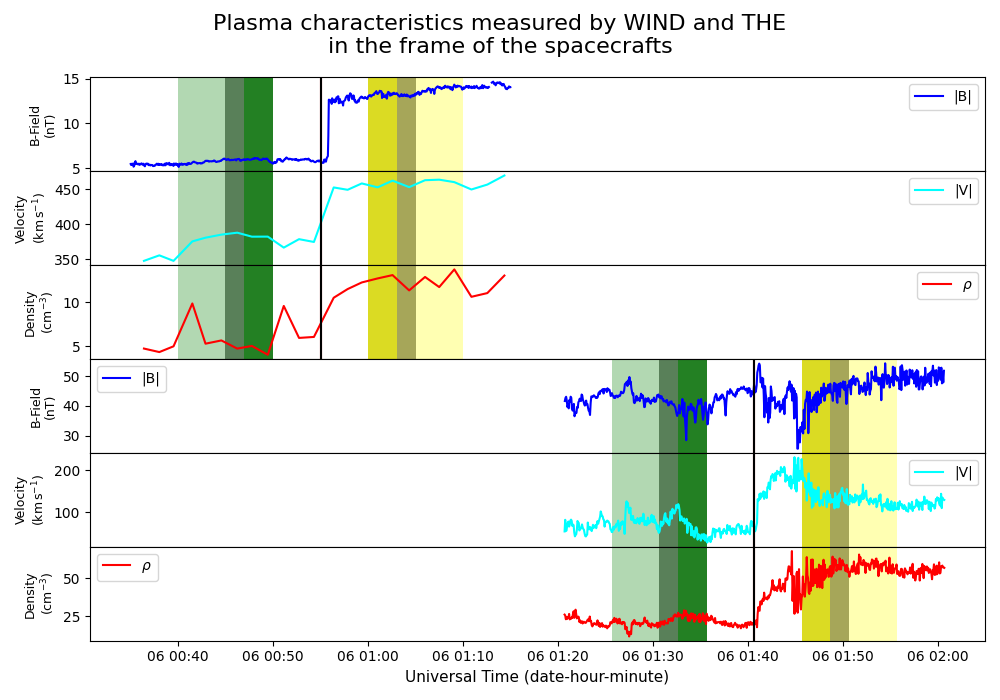

In [27]:
#--------------- plot of SW ---------------

fig_sw = plt.figure(figsize=(10, 7))
gs_sw = fig_sw.add_gridspec(6, hspace=0)
axes_sw = gs_sw.subplots(sharex=True, sharey=False)

plt.xlabel('Universal Time (date-hour-minute)',fontsize = 11)

axes_sw[0].plot(time_mag_sw, [calc_func.magnitude(lst) for lst in B_sw], color='blue', label = '|B|')
axes_sw[0].legend()
axes_sw[0].axvline(time_shock_sw, c = 'red')
axes_sw[0].set_ylabel('B-Field\n(nT)', fontsize = 9)
plot_line(time_up_sw,time_dw_sw,up_window_sw,down_window_sw, up_shk_sw, dw_shk_sw,time_shock_sw,ax=axes_sw[0])

axes_sw[1].plot(time_vel_sw, [calc_func.magnitude(lst) for lst in V_sw], color='cyan', label = '|V|')
axes_sw[1].legend()
axes_sw[1].axvline(time_shock_sw, c = 'red')
axes_sw[1].set_ylabel('Velocity\n'+r'($\mathrm{km\,s^{-1}}$)', fontsize = 9)
plot_line(time_up_sw,time_dw_sw,up_window_sw,down_window_sw, up_shk_sw, dw_shk_sw,time_shock_sw,ax=axes_sw[1])

axes_sw[2].plot(time_rho_sw, Rho_sw, color='red', label = r'$\rho$')
axes_sw[2].legend()
axes_sw[2].axvline(time_shock_sw, c = 'red')
axes_sw[2].set_ylabel('Density\n'+r'($\mathrm{cm^{-3}}$)', fontsize = 9)
plot_line(time_up_sw,time_dw_sw,up_window_sw,down_window_sw, up_shk_sw, dw_shk_sw,time_shock_sw,ax=axes_sw[2])

fig_sw.suptitle(f'Plasma characteristics measured by: {name_spacecraft_sw}', fontsize = 16)
plt.tight_layout()


#--------------- plot of MSH ---------------

axes_sw[3].plot(time_mag_msh, [calc_func.magnitude(lst) for lst in B_msh], color='blue', label = '|B|')
axes_sw[3].legend()
axes_sw[3].axvline(time_shock_msh, c = 'red')
axes_sw[3].set_ylabel('B-Field\n(nT)', fontsize = 9)
plot_line(time_up_msh,time_dw_msh,up_window_msh,down_window_msh, up_shk_msh, dw_shk_msh,time_shock_msh,ax=axes_sw[3])

axes_sw[4].plot(time_vel_msh, [calc_func.magnitude(lst) for lst in V_msh], color='cyan', label = '|V|')
axes_sw[4].legend()
axes_sw[4].axvline(time_shock_msh, c = 'red')
axes_sw[4].set_ylabel('Velocity\n'+r'($\mathrm{km\,s^{-1}}$)', fontsize = 9)
plot_line(time_up_msh,time_dw_msh,up_window_msh,down_window_msh, up_shk_msh, dw_shk_msh,time_shock_msh,ax=axes_sw[4])

axes_sw[5].plot(time_rho_msh, Rho_msh, color='red', label = r'$\rho$')
axes_sw[5].legend()
axes_sw[5].axvline(time_shock_msh, c = 'red')
axes_sw[5].set_ylabel('Density\n'+r'($\mathrm{cm^{-3}}$)', fontsize = 9)
plot_line(time_up_msh,time_dw_msh,up_window_msh,down_window_msh, up_shk_msh, dw_shk_msh,time_shock_msh,ax=axes_sw[5])

fig_sw.suptitle(f'Plasma characteristics measured by {name_spacecraft_sw} and {name_spacecraft_msh}\nin the frame of the spacecrafts', fontsize = 16)
plt.tight_layout()

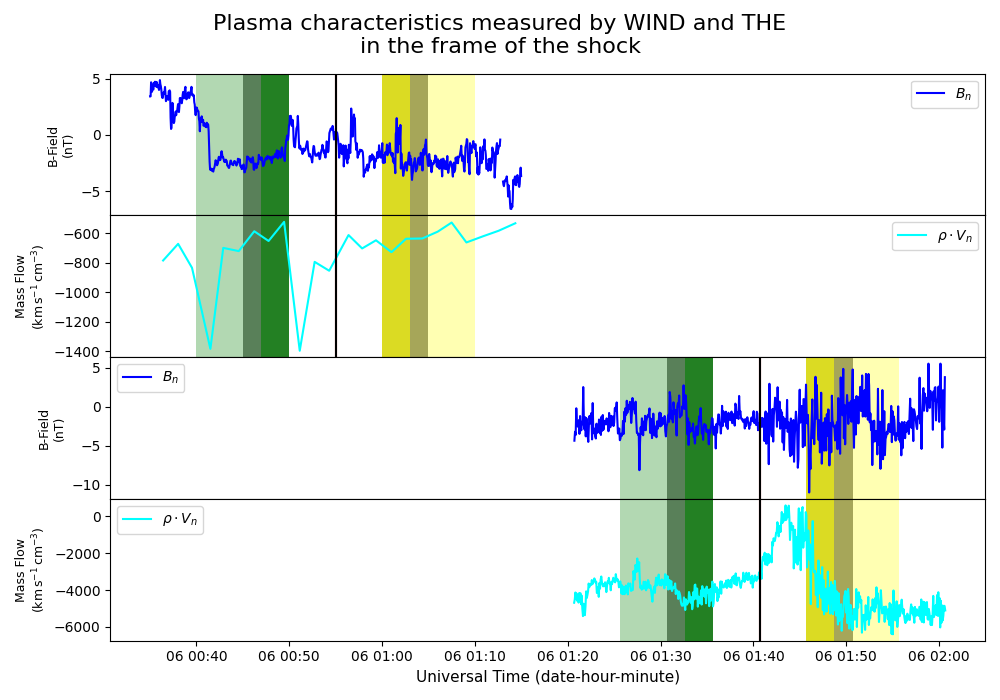

In [28]:
#--------------- calculations ---------------

normal_MX3_sw = data_func.nom_vals(avg_normals_sw[-1])
speed_MX3_sw = avg_speeds_sw[-1].n
Bn_sw = np.dot(B_sw,normal_MX3_sw)

normal_MX3_sw = normal_MX3_sw / calc_func.magnitude(normal_MX3_sw)
V_SH_sw = V_sw - speed_MX3_sw*normal_MX3_sw
V_SH_n_sw = RH.project_vector(V_SH_sw, normal_MX3_sw)


normal_MX3_msh = data_func.nom_vals(avg_normals_msh[-1])
normal_MX3_msh = normal_MX3_msh / calc_func.magnitude(normal_MX3_msh)

speed_MX3_msh = avg_speeds_msh[-1].n
Bn_msh = np.dot(B_msh,normal_MX3_msh)

V_SH_msh = V_msh - speed_MX3_msh*normal_MX3_msh
V_SH_n_msh = RH.project_vector(V_SH_msh, normal_MX3_msh)


#--------------- plot of SW ---------------

fig_sw = plt.figure(figsize=(10, 7))
gs_sw = fig_sw.add_gridspec(4, hspace=0)
axes_sw = gs_sw.subplots(sharex=True, sharey=False)

plt.xlabel('Universal Time (date-hour-minute)',fontsize = 11)

axes_sw[0].plot(time_mag_sw, Bn_sw, color='blue', label = r'$B_n$')
axes_sw[0].legend()
axes_sw[0].axvline(time_shock_sw, c = 'red')
axes_sw[0].set_ylabel('B-Field\n(nT)', fontsize = 9)
plot_line(time_up_sw,time_dw_sw,up_window_sw,down_window_sw, up_shk_sw, dw_shk_sw,time_shock_sw,ax=axes_sw[0])


axes_sw[1].plot(time_vel_sw, Rho_sw*V_SH_n_sw, color='cyan', label = r'$\rho\cdot V_n$')
axes_sw[1].legend()
axes_sw[1].axvline(time_shock_sw, c = 'red')
axes_sw[1].set_ylabel('Mass Flow\n'+r'$(\mathrm{km\,s^{-1}\,cm^{-3}})$', fontsize = 9)
plot_line(time_up_sw,time_dw_sw,up_window_sw,down_window_sw, up_shk_sw, dw_shk_sw,time_shock_sw,ax=axes_sw[1])

fig_sw.suptitle(f'Plasma characteristics measured by: {name_spacecraft_sw}', fontsize = 16)
plt.tight_layout()


#--------------- plot of msh ---------------

Bn_msh = np.dot(B_msh,data_func.nom_vals(avg_normals_msh[-1]))
Vn_msh = np.dot(V_msh,data_func.nom_vals(avg_normals_msh[-1]))

axes_sw[2].plot(time_mag_msh, Bn_msh, color='blue', label = r'$B_n$')
axes_sw[2].legend()
axes_sw[2].axvline(time_shock_msh, c = 'red')
axes_sw[2].set_ylabel('B-Field\n(nT)', fontsize = 9)
plot_line(time_up_msh,time_dw_msh,up_window_msh,down_window_msh, up_shk_msh, dw_shk_msh,time_shock_msh,ax=axes_sw[2])


axes_sw[3].plot(time_vel_msh, Rho_msh*V_SH_n_msh, color='cyan', label = r'$\rho\cdot V_n$')
axes_sw[3].legend()
axes_sw[3].axvline(time_shock_msh, c = 'red')
axes_sw[3].set_ylabel('Mass Flow\n'+'$(\mathrm{km\,s^{-1}\,cm^{-3}})$', fontsize = 9)
plot_line(time_up_msh,time_dw_msh,up_window_msh,down_window_msh, up_shk_msh, dw_shk_msh,time_shock_msh,ax=axes_sw[3])

fig_sw.suptitle(f'Plasma characteristics measured by {name_spacecraft_sw} and {name_spacecraft_msh}\nin the frame of the shock', fontsize = 16)
plt.tight_layout()